In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, accuracy_score, recall_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE, ADASYN
import category_encoders as ce
import xgboost as xgb
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

import sys
import os
import pickle
import time

# Add the path to the project root directory to the python path
sys.path.append(os.path.abspath("C:/Users/mabid/OneDrive/Desktop/Projects - Ongoing/BNP Credit Card Fraud Detection/fraud_detection/"))

from src.features import build_features

In [2]:
MODEL_RANK = -1
EVAL_DATA = '../data/processed/model_validation_data.csv'

# Show models that are in the models directory that has "16" in its name
active_models = [model for model in os.listdir('../models/') if '16' in model]
print(active_models)
MODEL_PATH = active_models[MODEL_RANK]

['01-Anas-XGBTuned-16_Feb_2024_06_48_04.pickle', '01-Anas-XGBTuned-16_Feb_2024_06_52_44.pickle', '01-Anas-XGBTuned-16_Feb_2024_07_10_22.pickle', '01-Anas-XGBTuned-16_Feb_2024_07_12_25.pickle', '01-Anas-XGBTuned-16_Feb_2024_07_14_13.pickle']


In [3]:
# Load the model
with open(f'../models/{MODEL_PATH}', 'rb') as file:
    model_args = pickle.load(file)

In [51]:
# Unpack the model arguments
class Model():
    def __init__(self, model_args):
        self.model = model_args['model']
        self.pipe = model_args['pipe']
        self.model_name = model_args['model_name']
        self.prediction_matrix_type = model_args['prediction_matrix_type']
        self.y_true_train = model_args['y_true_train']
        self.y_pred_train = model_args['y_pred_train']
        self.y_true_test = model_args['y_true_test']
        self.y_pred_test = model_args['y_pred_test']
        self.y_pred_valid = None
        self.y_true_valid = None

model_XGB = Model(model_args)

# Load the evaluation data
eval_data = pd.read_csv(EVAL_DATA)
X_eval = eval_data.drop('fraud_flag', axis=1)
y_eval = eval_data['fraud_flag']

# Transform the evaluation data
X_eval = model_XGB.pipe.transform(X_eval)
if model_XGB.prediction_matrix_type == 'xgb.DMatrix':
    X_eval = xgb.DMatrix(X_eval)

model_XGB.y_pred_valid = model_XGB.model.predict(X_eval)
model_XGB.y_true_valid = y_eval

C:\Users\mabid\AppData\Local\Temp\ipykernel_21872\3831069368.py:18: DtypeWarning: Columns (104,105,106,107,108,109,110,111,112,113,114,115,117,118,119,120) have mixed types. Specify dtype option on import or set low_memory=False.
  eval_data = pd.read_csv(EVAL_DATA)


Evaluation Metrics for XGBoost


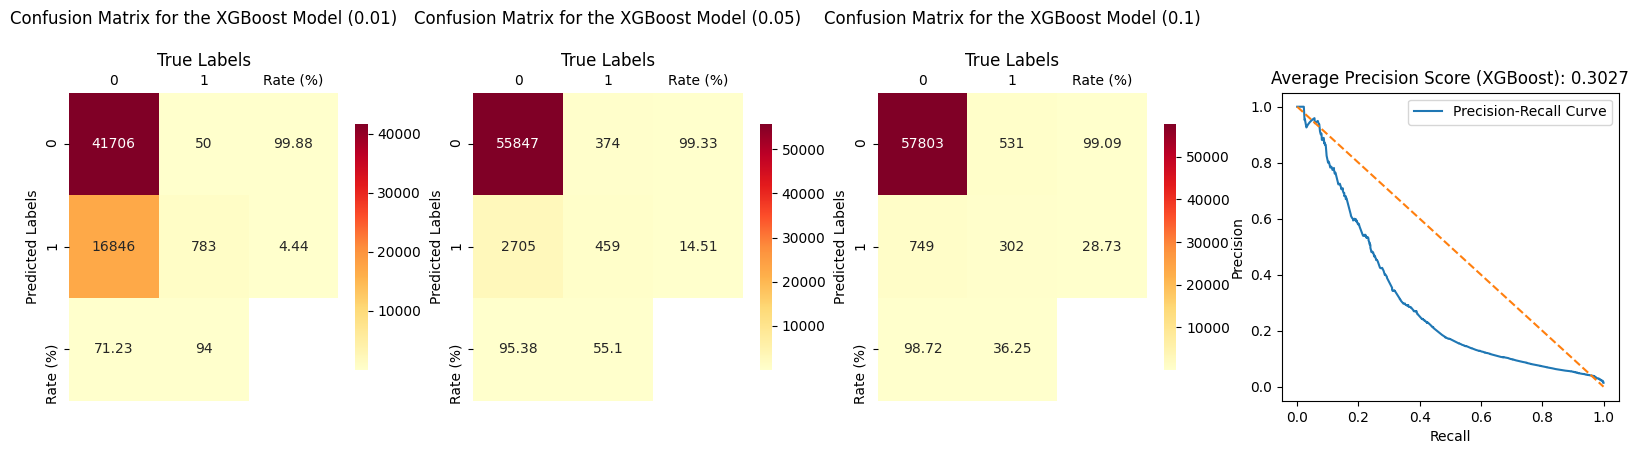

<Figure size 640x480 with 0 Axes>

In [50]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def modified_confusion_matrix(true_labels, pred_labels, model_name, threshold, ax):

    pred_labels = (pred_labels > threshold).astype(int)

    cm = confusion_matrix(pred_labels, true_labels)

    scores_df = pd.DataFrame(precision_recall_fscore_support(pred_labels, true_labels)).T
    scores_df.columns = ["precision", "recall", "fscore", "support"]
    scores_df[['precision', 'recall', 'fscore']] = scores_df[['precision', 'recall', 'fscore']] * 100
    scores_df = scores_df.round({'precision': 2, 'recall': 2, 'fscore': 2})
    overall_accuracy = "{:.2%}".format(accuracy_score(pred_labels, true_labels))
    res = pd.concat([pd.DataFrame(cm), scores_df['recall']], axis=1)
    res = pd.concat([res, scores_df['precision'].to_frame().T], axis=0)

    heatmap = sns.heatmap(res, annot=True, fmt='g', cmap="YlOrRd", cbar_kws={'shrink': 0.8}, ax=ax)
    ax.set_xticklabels([str(i) for i in range(2)] + ["Rate (%)"])
    ax.set_yticklabels([str(i) for i in range(2)] + ["Rate (%)"])
    ax.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True, length=0)
    ax.set_ylabel('Predicted Labels')
    ax.set_title(f"Confusion Matrix for the {model_name} Model " + f"({threshold})" + '\n' + '\n' + r"True Labels", multialignment='center')
    ax.set_frame_on(False)

def plot_precision_recall_curve(true_labels, pred_labels, model_name, ax=None):
    precision, recall, thresholds = precision_recall_curve(true_labels, pred_labels)
    map = average_precision_score(true_labels, pred_labels)

    ax.plot(recall, precision, label='Precision-Recall Curve')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Average Precision Score ({model_name}): {map:.4f}')
    ax.legend()

    # Plot the baseline diagonal line
    ax.plot([0, 1], [1, 0], linestyle='--', label='Baseline')

    plt.show()

thresholds = [0.01, 0.05, 0.1]
print(f'Evaluation Metrics for {model_XGB.model_name}')

# Create a single subplot with four columns
fig, ax = plt.subplots(1, 4, figsize=(20, 4))  # Adjust figsize as needed

# Iterate through thresholds and plot confusion matrix for each
for i, threshold in enumerate(thresholds):
    ax_i = ax[i]  # Select the current subplot
    modified_confusion_matrix(model_XGB.y_true_train, model_XGB.y_pred_train, model_XGB.model_name, threshold, ax_i)

# Plot the precision-recall curve
ax_pr = ax[-1]  # Select the last subplot
plot_precision_recall_curve(model_XGB.y_true_train, model_XGB.y_pred_train, model_XGB.model_name, ax_pr)

plt.tight_layout()
plt.show()


In [41]:
model_XGB.y_true_train

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

Evaluation Metrics for XGBoost


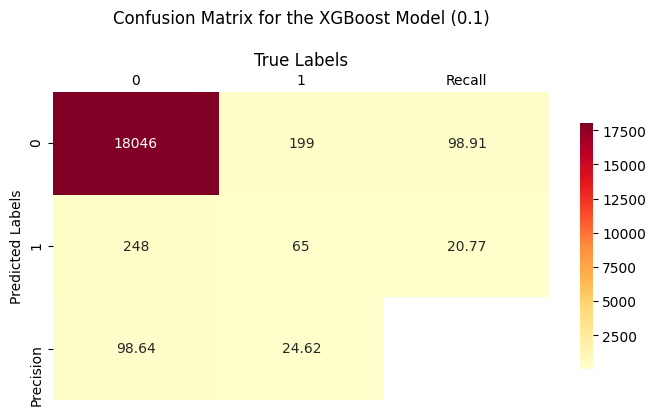

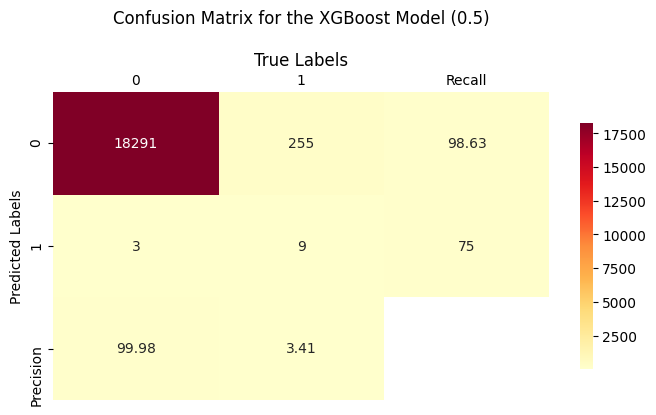

c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


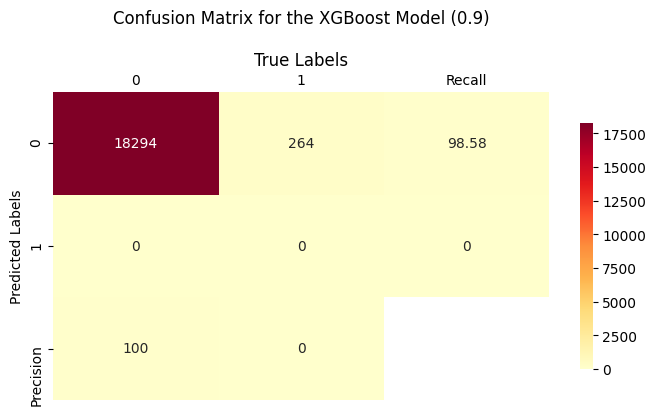

In [ ]:
# Print the evaluation metrics for training set
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, precision_recall_curve, auc
thresholds = [.1, .5, .9]
print(f'Evaluation Metrics for {model_XGB.model_name}')

#Confusion Matrix for each threshold
fig, ax = plt.subplots(1, 3, figsize=(8, 4))
for threshold in thresholds:
    modified_confusion_matrix(model_XGB.y_pred_valid, model_XGB.y_true_valid, model_XGB.model_name, threshold)

In [26]:
model_XGB.y_pred_valid = model_XGB.model.predict(eval_data)

In [5]:
eval_data = pd.read_csv(EVAL_DATA)
eval_data

C:\Users\mabid\AppData\Local\Temp\ipykernel_21872\2534171464.py:1: DtypeWarning: Columns (104,105,106,107,108,109,110,111,112,113,114,115,117,118,119,120) have mixed types. Specify dtype option on import or set low_memory=False.
  eval_data = pd.read_csv(EVAL_DATA)


,ID,item1,item2,item3,item4,item5,item6,item7,item8,item9,...,Nbr_of_prod_purchas17,Nbr_of_prod_purchas18,Nbr_of_prod_purchas19,Nbr_of_prod_purchas20,Nbr_of_prod_purchas21,Nbr_of_prod_purchas22,Nbr_of_prod_purchas23,Nbr_of_prod_purchas24,Nb_of_items,fraud_flag
0,38100,TELEVISIONS HOME CINEMA,TELEVISIONS HOME CINEMA,AUDIO ACCESSORIES,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0
1,13409,BEDROOM FURNITURE,BEDROOM FURNITURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0
2,56447,TELEVISIONS HOME CINEMA,FULFILMENT CHARGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0
3,94627,COMPUTERS,COMPUTER PERIPHERALS ACCESSORIES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0
4,11531,COMPUTERS,COMPUTER SOFTWARE,FULFILMENT CHARGE,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18553,16785,"TELEPHONES, FAX MACHINES & TWO-WAY RADIOS",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0
18554,11514,COMPUTER PERIPHERALS & ACCESSORIES,WARRANTY,AUDIO ACCESSORIES,WARRANTY,FULFILMENT CHARGE,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,0
18555,26807,COMPUTERS,COMPUTER PERIPHERALS ACCESSORIES,BAGS CARRY CASES,FULFILMENT CHARGE,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0
18556,84360,COMPUTERS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0
